In [ ]:
# %%html
# <style>

# .mytext > .widget-label {
#     font-style: italic;
#     color: blue;
#     font-size: 30px;
# }
# .mytext > input[type="text"] {
#     font-size: 20px;
#     color: red;
# }

# </style>

In [1]:
# NOTE: this notebook is not refactored to be up to date

import re
import random
import json
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from collections import Counter

import openai
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from game_data_utils import get_all_phase_dialogues, build_dialogue_text
from constants import *
from api_utils import get_rating, completion_cached, get_rating_for_dialogue
from prompt_templates import *

In [2]:
# list all the prompts
for phase_dialogue, cicero_power, human_power, game_id in get_all_phase_dialogues():
    print(f"Cicero is: {cicero_power}\n")
    print(f"Game ID: {game_id}\n")
    text = build_dialogue_text(phase_dialogue)
    print(text)
    print("=====================================================\n\n")

Cicero is: RUSSIA

Game ID: 444641

RUSSIA:   Are England and Germany working together?

FRANCE:   Nope

RUSSIA:   Hmm. What's England up to then?

FRANCE:   I guess they're attacking Germany

FRANCE:   and now probably you too because you took Nwy

RUSSIA:   Well, maybe he'll work with you against Germany instead of Germany against you.




Cicero is: RUSSIA

Game ID: 444641

RUSSIA:   Maybe you should stop trying to take Italian centres. You need to defend yourself against Germany.

FRANCE:   yes, I did disband in Rome

RUSSIA:   I noticed.

RUSSIA:   You should take back Brest.

FRANCE:   I'm trying that

RUSSIA:   Great.




Cicero is: RUSSIA

Game ID: 444641

RUSSIA:   We should work together.

FRANCE:   sure, how

RUSSIA:   Can you go to North Sea?

FRANCE:   yes

RUSSIA:   I'll bounce him in Kiel.

FRANCE:   ok




Cicero is: RUSSIA

Game ID: 444641

RUSSIA:   Hi Italy! What are your plans for the first couple of years? Would you be up for working together against Austria or Tur

In [ ]:
# answer random dialogue
dialogue, cicero_power, human_power, game_id = random.choice(list(get_all_phase_dialogues()))

text = build_dialogue_text(dialogue)
prompt = cooperation_prompt1.format(cicero_power=cicero_power, human_power=human_power)

print(f"( Cicero is: {cicero_power} )\n")
print(text + prompt)

response = openai.Completion.create(
    model="text-davinci-003",
    # model="text-curie-001",
    prompt=text + prompt,
    max_tokens=300,
)["choices"][0]["text"]

print(response)

# Comparing models

In [ ]:
ratings_comparison = dict()

In [ ]:
# remove None values
x, y = ratings_comparison["text-davinci-003"], ratings_comparison["text-curie-001"]
x, y = np.array(x), np.array(y)
none_indexes = (x == None) | (y == None)
x = x[~none_indexes]
y = y[~none_indexes]

x_ranks = stats.rankdata(x) / len(x)
y_ranks = stats.rankdata(y) / len(y)

In [ ]:
# make the plot square
plt.figure(figsize=(6, 6))

# add noise to make the graph more readable
x_noise = np.random.normal(0, 0.01, len(x_ranks))
y_noise = np.random.normal(0, 0.01, len(y_ranks))

plt.scatter(x_ranks + x_noise, y_ranks + y_noise, s=1, alpha=1.0)

plt.xlabel("davinci-003")
plt.ylabel("curie-001")

plt.xlim(0, 1)
plt.ylim(0, 1)

corr = np.corrcoef(x_ranks, y_ranks)
print(f"Correlation: {corr[0, 1]:.2f}")

Dialogs with None rating:  0%
Entropy of ratings:        1.16 bits


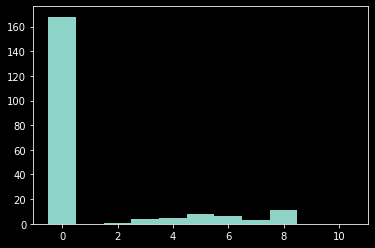

In [ ]:
raw_ratings = [info["rating"] for info in dialogue_ratings]
ratings = list(filter(lambda x: x is not None, raw_ratings))

print(
    f"Dialogs with None rating:  {100 * sum(1 for info in dialogue_ratings if info['rating'] is None) / len(dialogue_ratings):.0f}%"
)
probs = [count / len(ratings) for count in Counter(ratings).values()]
print(f"Entropy of ratings:        {stats.entropy(probs, base=2):.2f} bits")

# get a histogram of ratings
plt.hist(ratings, bins=np.arange(-0.5, 11.5, 1))
None
